In [1]:
import pandas as pd
import anndata as ad
from pathlib import Path
import os
import sys
import numpy as np
import scanpy as sc

from omegaconf import OmegaConf, DictConfig

import matplotlib.pyplot as plt
from matplotlib_venn import venn2

import seaborn as sns

In [2]:
repo_dir = '/home/projects/amit/annaku/repos/Blueprint'
sys.path.append(os.path.join(repo_dir, 'src'))

In [3]:
from data_loading.utils import load_dataframe_from_file, get_updated_disease_col
from clinical_predictions.clinical_data_loading import (
    load_and_process_clinical_data, 
    add_general_response_cens, 
    add_general_response, 
    add_Kydar_response,
    add_CART_response,
    generate_gen_info
)
from pre_processing.utils import count_number_of_annotation_in_neighborhood, add_number_of_patients_in_neighborhood

/home/projects/amit/annaku/repos/Blueprint/src/clinical_predictions/clinical_data_loading.py:214: SyntaxWarning: invalid escape sequence '\.'
  treated_alone_mask = (~ dataset[dataset.columns[dataset.columns.str.contains("\.2")]].isna()).sum(axis=1) == 1


# vars

In [4]:
config_path = '/home/projects/amit/annaku/repos/Blueprint/configs/config.yaml'
conf = OmegaConf.load(config_path)

In [5]:
version = conf['data_loading']['version']
data_path = conf['outputs']['output_dir']
clin_file_path = conf['annotation']['clinical_data']['clinical_data_file_path']

print(version,'\n', data_path,'\n', clin_file_path)

20250306 
 /home/projects/amit/annaku/repos/Blueprint/data/processed 
 /home/projects/amit/annaku/data/mm_2023/clinical_prediction/Anonymized_CRF_BP_04_05_2025.xlsx


In [6]:
md_version = '04-05-2025'

In [7]:
additional_filt = True # pc additional filt (leiden, neighbours)

# TME + PC together

In [10]:
date = '2025-08-25'
adata_proc = ad.read_h5ad(os.path.join(data_path,
                                       f'adata_with_scvi_full_annot_pred_data_v_{version}_ts_{date}.h5ad'))

In [11]:
import gc

gc.collect()

111

In [13]:
# PC filt

super_pop = conf['annotation']['major_cell_type_column']

count_number_of_annotation_in_neighborhood(adata_proc, super_pop, "CD45")
count_number_of_annotation_in_neighborhood(adata_proc, super_pop, "PC")

adata_proc.obs["bad_pcs"] = (adata_proc.obs[super_pop]=="PC") & (adata_proc.obs['count_of_PC_in_neighborhood'] < adata_proc.obs['count_of_CD45_in_neighborhood'])
print('bad_pcs: ', adata_proc.obs["bad_pcs"].sum())

##

cluster_annot = {}
for c, group in adata_proc.obs[["leiden", super_pop]].groupby("leiden"):
    cluster_annot[c] = group.value_counts().index[0][1]

adata_proc.obs["bad_pcs_leiden"] = (adata_proc.obs[super_pop]=="PC") & (adata_proc.obs['leiden'].apply(lambda x: cluster_annot[x]=="CD45"))
print('bad_pcs_leiden: ', adata_proc.obs["bad_pcs_leiden"].sum())

##

adata_proc.obs["bad_pcs_all"] = ((adata_proc.obs["bad_pcs_leiden"]) | (adata_proc.obs["bad_pcs"]))
print(adata_proc.obs["bad_pcs_all"].sum())

pc_close_other_pc_col = "pc_close_other_pc"
adata_proc.obs[pc_close_other_pc_col] = (adata_proc.obs[super_pop] =='PC') & (~ adata_proc.obs["bad_pcs_all"])
print('pc_close_other_pc: ', adata_proc.obs["pc_close_other_pc"].sum())

##

if additional_filt:

    adata_proc = adata_proc[~adata_proc.obs["bad_pcs_all"]]
    adata_proc

    adata_only_pc = adata_proc[adata_proc.obs['Populations'].isin(['Malignant', 'Normal_PC', 'Interm', 'Normal_Pb'])].copy()
    adata_only_pc.obs['log_total_counts'] = np.log(adata_only_pc.obs['total_counts'])
    adata_only_pc.obs['noisy_malignant_by_umi'] = ((adata_only_pc.obs["log_total_counts"] < 6.5) & 
                                            (adata_only_pc.obs['Populations']=="Malignant")).astype("category")
    
    # exclude noisy by umi malignant cells
    noisy_by_umi_malignant_cells = adata_only_pc[adata_only_pc.obs['noisy_malignant_by_umi']==True].obs.index
    print('noisy malignant cells (!): ' ,len(noisy_by_umi_malignant_cells))

    adata_proc = adata_proc[~adata_proc.obs.index.isin(noisy_by_umi_malignant_cells)]
    adata_proc

bad_pcs:  278
bad_pcs_leiden:  289
474
pc_close_other_pc:  207696


/tmp/ipykernel_2176233/2911543699.py:14: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for c, group in adata_proc.obs[["leiden", super_pop]].groupby("leiden"):


noisy malignant cells (!):  23449


In [16]:
# same for cd45

adata_proc.obs["bad_cd45s"] = (adata_proc.obs[super_pop]=="CD45") & (adata_proc.obs['count_of_CD45_in_neighborhood'] < adata_proc.obs['count_of_PC_in_neighborhood'])
adata_proc.obs["bad_cd45s_leiden"] = (adata_proc.obs[super_pop]=="CD45") & (adata_proc.obs['leiden'].apply(lambda x: cluster_annot[x]=="PC"))
adata_proc.obs["bad_cd45s_all"] = ((adata_proc.obs["bad_cd45s_leiden"]) | (adata_proc.obs["bad_cd45s"]))
print(adata_proc.obs["bad_cd45s_all"].sum())
adata_proc = adata_proc[~(adata_proc.obs["bad_pcs_all"] | adata_proc.obs["bad_cd45s_all"])]
adata_proc

/tmp/ipykernel_2176233/2285267635.py:3: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata_proc.obs["bad_cd45s"] = (adata_proc.obs[super_pop]=="CD45") & (adata_proc.obs['count_of_CD45_in_neighborhood'] < adata_proc.obs['count_of_PC_in_neighborhood'])


1274


View of AnnData object with n_obs × n_vars = 547976 × 3862
    obs: 'Unnamed: 0', 'Amp.Batch.ID', 'Seq.Batch.ID', 'Batch.Set.ID', 'Included', 'Tissue', 'Gating', 'Total.PC', 'Total.NonPC', 'Initial.Code', 'Disease', 'Time', 'Project', 'Cohort', 'Weizmann.Code', 'Hospital.Code', 'Clinical.Data', 'Biopsy.Sequence', 'Previous.Hospital.Code', 'Method', 'cID', 'super_Population', 'Populations', 'n_genes', 'n_counts', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', '_scvi_batch', '_scvi_labels', 'leiden', 'Predicted', 'count_of_CD45_in_neighborhood', 'count_of_PC_in_neighborhood', 'bad_pcs', 'bad_pcs_leiden', 'bad_pcs_all', 'pc_close_other_pc', 'bad_cd45s', 'bad_cd45s_leiden', 'bad_cd45s_all'
    var: 'n_cells', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts'
    uns: '_scvi_manager_uuid', '_scvi_uuid', 'leiden', 'log1p', 'neighbors', 'umap'
    obsm: 'X_scVI', 'X_umap'
    layers: 'counts'
    obsp: 'connectivities', 'distances'

In [17]:
display(adata_proc.obs['Populations'].value_counts(dropna = False))

mask = ~adata_proc.obs['Populations'].isin(['UN', 'nan', 'Erythrocytes'])
adata_proc = adata_proc[mask].copy()
adata_proc

Populations
Malignant          141570
Mo                  97737
T_Naive             65286
T_Effector_GZMB     40508
T_Effector          34253
Normal_PC           32163
B                   27537
Mo_CD16             19456
DC                  18731
NK                  11922
Erythrocytes        11475
Interm               7762
B_Pro                7239
Mf                   5775
UN                   5485
pDC                  4649
Mo_Pro               3737
Mast                 2865
DC_IRF8              2782
Normal_Pb            2752
Neu_Pro              2075
Mega                 1197
Fibro                1020
Name: count, dtype: int64

AnnData object with n_obs × n_vars = 531016 × 3862
    obs: 'Unnamed: 0', 'Amp.Batch.ID', 'Seq.Batch.ID', 'Batch.Set.ID', 'Included', 'Tissue', 'Gating', 'Total.PC', 'Total.NonPC', 'Initial.Code', 'Disease', 'Time', 'Project', 'Cohort', 'Weizmann.Code', 'Hospital.Code', 'Clinical.Data', 'Biopsy.Sequence', 'Previous.Hospital.Code', 'Method', 'cID', 'super_Population', 'Populations', 'n_genes', 'n_counts', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', '_scvi_batch', '_scvi_labels', 'leiden', 'Predicted', 'count_of_CD45_in_neighborhood', 'count_of_PC_in_neighborhood', 'bad_pcs', 'bad_pcs_leiden', 'bad_pcs_all', 'pc_close_other_pc', 'bad_cd45s', 'bad_cd45s_leiden', 'bad_cd45s_all'
    var: 'n_cells', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts'
    uns: '_scvi_manager_uuid', '_scvi_uuid', 'leiden', 'log1p', 'neighbors', 'umap'
    obsm: 'X_scVI', 'X_umap'
    layers: 'counts'
    obsp: 'connectivities', 'distances'

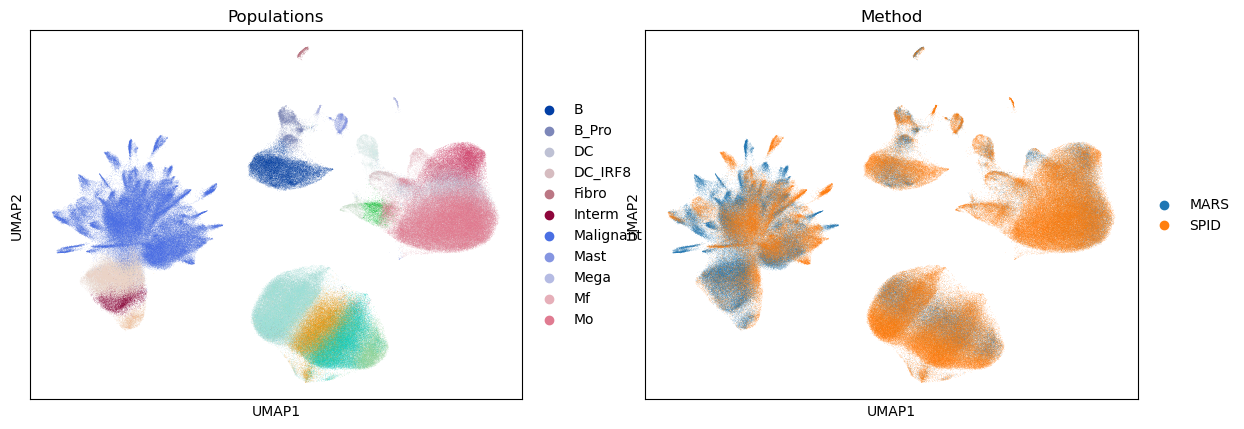

In [18]:
# long

sc.pp.neighbors(adata_proc,
                use_rep='X_scVI',
                    n_neighbors=30,
                    key_added='tme')
sc.tl.umap(adata_proc,
            neighbors_key='tme', 
            min_dist = 0.3,
           )

sc.pl.umap(adata_proc,
            color = ['Populations', 'Method'],
           )

updaed diseases:  Disease
RRMM              323861
non_naive_NDMM     89342
NDMM               35909
AL                 22498
SMM                20603
Healthy            19952
MGUS               17822
MM_Unknown          1029
Name: count, dtype: int64


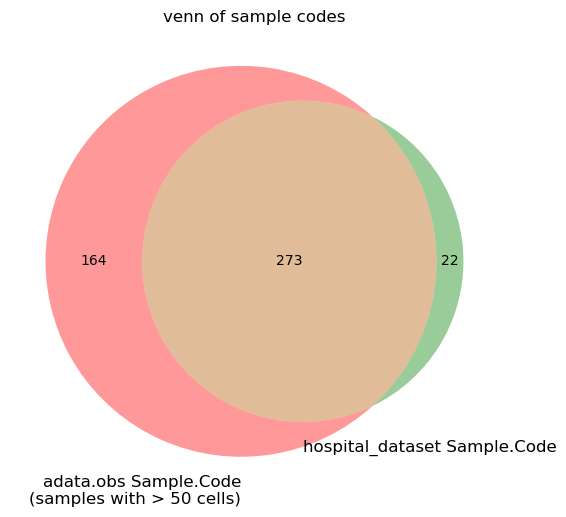

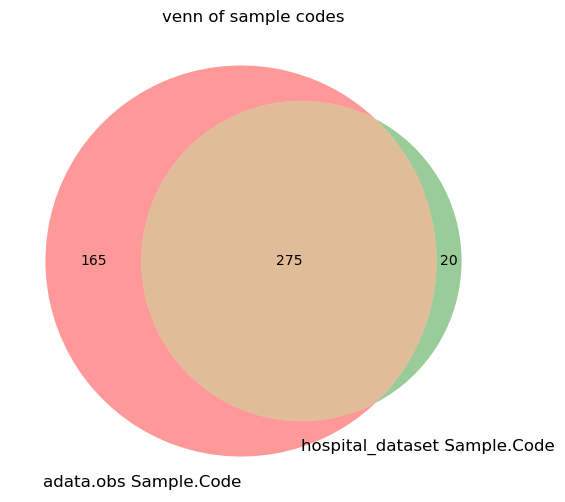

In [20]:
#merge with clinical data

adata_proc.obs['Hospital.Code'] = adata_proc.obs['Hospital.Code'].str.lower()
adata_proc.obs['Sample.Code'] = adata_proc.obs['Hospital.Code'].astype(str) + '_' +  adata_proc.obs['Biopsy.Sequence'].astype(int).astype(str)
adata_proc.obs['Populations_with_pc_and_pb'] = adata_proc.obs['Populations'].copy()
adata_proc.obs['Populations_with_pc'] = adata_proc.obs['Populations_with_pc_and_pb'].copy().replace({'Interm':'Healthy_Like',
                                                                                           'Normal_Pb':'Healthy_Like',
                                                                                           'Normal_PC':'Healthy'})

new_hospital_dataset = pd.read_excel(clin_file_path, sheet_name='Clinical Data')
new_hospital_dataset['Sample.Code'] = new_hospital_dataset['Code'].str.lower() + '_' + new_hospital_dataset['Biopsy sequence No.'].astype(int).astype(str)

# merging

merged_obs = adata_proc.obs.reset_index().merge(
    new_hospital_dataset,
    how='left',
    left_on = 'Sample.Code',
    right_on = 'Sample.Code',
    validate='m:1'
).set_index('index')

adata_proc.obs = merged_obs
adata_proc.obs.rename(columns = {'Cytogenetics Risk (1=standard risk, 2=single hit, 3=2+ hits)':'Cyto_Risk'}, inplace=True)

# check disease updating

clinical_disease = load_and_process_clinical_data(Path(clin_file_path), code_lower_case=False, get_hospital_stage=True,
                                                 get_post_treatment=False, get_treatment_history=True,
                                                 get_combination_exposure=False, get_pfs_data=False)

clinical_disease['Code'] = clinical_disease['Code'].str.lower()

adata_proc.obs['Biopsy.Sequence'] = adata_proc.obs['Biopsy.Sequence'].astype(int)
merged = adata_proc.obs.merge(clinical_disease, how='left', 
                                        left_on=['Hospital.Code', 'Biopsy.Sequence'],
                                        right_on=['Code', 'Biopsy sequence No.'])
updated_disease_col = get_updated_disease_col(merged, "Disease", "Disease Stage Hospital", 
                                              update_non_naive_NDMM_by_treatment_history=False, remove_PRMM=False)
updated_disease_col.index = adata_proc.obs_names
adata_proc.obs['Disease'] = updated_disease_col
print('updaed diseases: ',adata_proc.obs['Disease'].value_counts(dropna = False))

# plotting

import matplotlib.pyplot as plt
from matplotlib_venn import venn2

# with filtering of number of cells
samples_with_enough_cells = adata_proc.obs['Sample.Code'].value_counts()[adata_proc.obs['Sample.Code'].value_counts() > 50].index
mask = adata_proc.obs['Sample.Code'].isin(samples_with_enough_cells)
set1 = set(adata_proc.obs['Sample.Code'][mask])
set2 = set(new_hospital_dataset['Sample.Code'])
intersection = set1.intersection(set2)
plt.figure(figsize=(10, 6))
venn2([set1, set2], ('adata.obs Sample.Code\n(samples with > 50 cells)', 'hospital_dataset Sample.Code'))
plt.title('venn of sample codes')
plt.show()

# without filtering of number of cells

set1 = set(adata_proc.obs['Sample.Code'])
set2 = set(new_hospital_dataset['Sample.Code'])
intersection = set1.intersection(set2)
plt.figure(figsize=(10, 6))
venn2([set1, set2], ('adata.obs Sample.Code', 'hospital_dataset Sample.Code'))
plt.title('venn of sample codes')
plt.show()

In [22]:
# gen cols

gen_cols = ['1q21+', 'del(1p)', 'del(13q)', 'del(17p)', 't(11:14)', 't(4:14)',
                 't(14:16)', 't(14:20)',
                 #'Cytogenetics Risk (1=standard risk, 2=single hit, 3=2+ hits)',
                 'Cyto_Risk'
                 ]

del_cols = ['1q21+',
 'del(1p)',
 'del(13q)',
 'del(17p)']

adata_proc.obs['Cyto_Risk'] = adata_proc.obs['Cyto_Risk'].replace({1.:'Standard Risk', 2.:'Single Hit', 3.:'2+ Hits'}).fillna('NA')
adata_proc.obs[gen_cols] = adata_proc.obs[gen_cols].fillna('NA').astype(str)
adata_proc.obs[gen_cols[:-1]] = adata_proc.obs[gen_cols[:-1]].replace({'0.0':'No', '1.0':'Yes'})
adata_proc.obs[gen_cols[:-1]] = adata_proc.obs[gen_cols[:-1]].astype(str)
adata_proc.obs['delampl_info'] = adata_proc.obs.apply(lambda row: generate_gen_info(row, del_cols), axis=1).fillna('NA').replace({'':'NA'})

In [23]:
# response

adata_proc.obs['Last FU Date'] = pd.to_datetime(adata_proc.obs['Last FU Date'], format='mixed',                                                dayfirst=True).dt.strftime('%m/%d/%Y')
adata_proc.obs['Biopsy date'] = pd.to_datetime(adata_proc.obs['Biopsy date'], format='mixed',
                                                dayfirst=True).dt.strftime('%m/%d/%Y')
CAR_T_full_clinical_data_path = Path('/home/projects/amit/annaku/data/mm_2023/clinical_prediction/CART MM responder vs non responder 160424.xlsx')

# cart only
for PFS_THR in [3, 6, 9]:

    adata_proc.obs['index'] = adata_proc.obs.index
    CAR_T_full_clinical_data = load_dataframe_from_file(CAR_T_full_clinical_data_path)
    all_metadata_df = add_CART_response(adata_proc.obs, full_clinical_df=CAR_T_full_clinical_data, pfs_policy=f"{str(PFS_THR)}M PFS")
    all_metadata_df.index = all_metadata_df['index']

    all_metadata_df = all_metadata_df.rename(columns = {'CART_response':f'CART_response_{PFS_THR}M',})
    adata_proc.obs = all_metadata_df

# pfs resp, cens and not cens
for PFS_THR in [3, 4, 6, 9]:

    adata_proc.obs['index'] = adata_proc.obs.index
    all_metadata_df = add_general_response(adata_proc.obs, pfs_thresh_months=PFS_THR)
    all_metadata_df = add_Kydar_response(all_metadata_df, number_of_months=PFS_THR)

    all_metadata_df.index = all_metadata_df['index']

    all_metadata_df = all_metadata_df.rename(columns = {'general_pfs_response':f'general_pfs_response_{PFS_THR}M',
                                                        'Kydar_response':f'Kydar_response_{PFS_THR}M',
                                                        }
                                                        )
    # with cens
    all_metadata_df = add_general_response_cens(all_metadata_df, pfs_thresh_months=PFS_THR)
    all_metadata_df[f'Kydar_response_cens_{PFS_THR}M'] = all_metadata_df[f'general_pfs_response_cens_{PFS_THR}M']
    all_metadata_df.loc[all_metadata_df['Project'] != 'Kydar', f'Kydar_response_cens_{PFS_THR}M'] = None

    adata_proc.obs = all_metadata_df

/home/projects/amit/annaku/repos/Blueprint/src/clinical_predictions/clinical_data_loading.py:293: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  patient_df[general_response_col][~patients_with_post_data] = 'no_data'
/home/projects/amit/annaku/repos/Blueprint/src/clinical_predictions/clinical_data_loading.py:310: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  patient_df[general_pfs_response_col][not_reliable_pfs] = 'no_data'
/home/projects/amit/annaku/repos/Blueprint/src/clinical_predictions/clinical_data_loading.py:311: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the ca

general_pfs_response_cens_3M
None    269650
R       221181
NR       40185
Name: count, dtype: int64


/home/projects/amit/annaku/repos/Blueprint/src/clinical_predictions/clinical_data_loading.py:293: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  patient_df[general_response_col][~patients_with_post_data] = 'no_data'
/home/projects/amit/annaku/repos/Blueprint/src/clinical_predictions/clinical_data_loading.py:310: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  patient_df[general_pfs_response_col][not_reliable_pfs] = 'no_data'
/home/projects/amit/annaku/repos/Blueprint/src/clinical_predictions/clinical_data_loading.py:311: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the ca

general_pfs_response_cens_4M
None    301727
R       182589
NR       46700
Name: count, dtype: int64


/home/projects/amit/annaku/repos/Blueprint/src/clinical_predictions/clinical_data_loading.py:293: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  patient_df[general_response_col][~patients_with_post_data] = 'no_data'
/home/projects/amit/annaku/repos/Blueprint/src/clinical_predictions/clinical_data_loading.py:310: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  patient_df[general_pfs_response_col][not_reliable_pfs] = 'no_data'
/home/projects/amit/annaku/repos/Blueprint/src/clinical_predictions/clinical_data_loading.py:311: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the ca

general_pfs_response_cens_6M
None    332639
R       134914
NR       63463
Name: count, dtype: int64


/home/projects/amit/annaku/repos/Blueprint/src/clinical_predictions/clinical_data_loading.py:293: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  patient_df[general_response_col][~patients_with_post_data] = 'no_data'
/home/projects/amit/annaku/repos/Blueprint/src/clinical_predictions/clinical_data_loading.py:310: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  patient_df[general_pfs_response_col][not_reliable_pfs] = 'no_data'
/home/projects/amit/annaku/repos/Blueprint/src/clinical_predictions/clinical_data_loading.py:311: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the ca

general_pfs_response_cens_9M
None    361854
NR       87347
R        81815
Name: count, dtype: int64


In [24]:
(all_metadata_df.index == adata_proc.obs.index).all()

True

In [25]:
adata_proc.obs = all_metadata_df

In [ ]:
# mark samples doubled between MARS and SPID (to exclude downstream after checking consistance between batches)

df = adata_proc.obs.copy()
sample_method_counts = df.groupby('Sample.Code')['Method'].nunique()
duplicated_samples = sample_method_counts[sample_method_counts > 1].index.tolist()
print(f"{len(duplicated_samples)} samples sequenced with multiple methods:")
print(duplicated_samples)

malignant_df = (df[df['Sample.Code'].isin(duplicated_samples)]
                .groupby(['Sample.Code', 'Method'], observed=True)
                .agg(n_malignant=('Populations', lambda x: (x == 'Malignant').sum()),
                     total_cells=('Populations', 'size'))
                .reset_index())

print("\nMalignant cell counts per sample-method:")
print(malignant_df)

remove_list = []

for sample in duplicated_samples:
    sample_data = malignant_df[malignant_df['Sample.Code'] == sample]
    
    if len(sample_data) != 2:
        continue
    
    min_idx = sample_data['n_malignant'].idxmin()
    method_to_remove = sample_data.loc[min_idx, 'Method']
    
    remove_list.append({
        'Sample.Code': sample,
        'Method': method_to_remove
    })

remove_df = pd.DataFrame(remove_list)
    
print("\nSamples to remove (method with fewer malignant cells):")
print(remove_df)

adata_proc.obs['cells_rem_dupl_between_methods'] = False

for _, row in remove_df.iterrows():
    mask = (adata_proc.obs['Sample.Code'] == row['Sample.Code']) & \
           (adata_proc.obs['Method'] == row['Method'])
    adata_proc.obs.loc[mask, 'cells_rem_dupl_between_methods'] = True

print(f"\nCells marked: {adata_proc.obs['cells_rem_dupl_between_methods'].sum()}")
print(f"Total cells: {adata_proc.n_obs}")

9 samples sequenced with multiple methods:
['cart_p19_1', 'cart_p21_1', 'cart_p24_1', 'cart_p25_1', 'cart_p36_1', 'tlv48_1', 'tlv53_1', 'tlv63_1', 'tlv69_1']

Malignant cell counts per sample-method:
   Sample.Code Method  n_malignant  total_cells
0   cart_p19_1   MARS          195          344
1   cart_p19_1   SPID           13         1012
2   cart_p21_1   MARS          414         1086
3   cart_p21_1   SPID          149          494
4   cart_p24_1   MARS          867         1384
5   cart_p24_1   SPID         1373         3370
6   cart_p25_1   MARS            7           41
7   cart_p25_1   SPID            0          419
8   cart_p36_1   MARS          891         1571
9   cart_p36_1   SPID          271          725
10     tlv48_1   MARS          104          749
11     tlv48_1   SPID            4         1508
12     tlv53_1   MARS          898         2053
13     tlv53_1   SPID          201          460
14     tlv63_1   MARS            0           20
15     tlv63_1   SPID           

In [29]:
# save adata

object_columns = adata_proc.obs.select_dtypes(include=['object']).columns
for col in object_columns:
    adata_proc.obs[col] = adata_proc.obs[col].astype(str)
datetime_columns = adata_proc.obs.select_dtypes(include=['datetime64']).columns
for col in datetime_columns:
    adata_proc.obs[col] = adata_proc.obs[col].dt.strftime('%Y-%m-%d %H:%M:%S')
name = os.path.join(data_path, f'adata_PC_and_TME_with_ann_merged_v_{version}_UMAP.h5ad')
adata_proc.write_h5ad(name)
print(f'saved to {name}')

/home/projects/amit/annaku/miniconda3/envs/cell2cell_env/lib/python3.12/site-packages/anndata/_io/utils.py:243: FutureWarning: Forward slashes will be disallowed in h5 stores in the next minor release
  return func(*args, **kwargs)


saved to /home/projects/amit/annaku/repos/Blueprint/data/processed/adata_PC_and_TME_with_ann_merged_v_20250306_UMAP.h5ad


In [30]:
# counts h5ad file
filename = f'pp_adata_data_v_{version}.h5ad'
adata_pp = ad.read_h5ad(os.path.join(data_path, filename)) # raw after basic QC

name = os.path.join(data_path, f'adata_PC_and_TME_with_ann_merged_v_{version}_UMAP.h5ad')
adata_proc = ad.read_h5ad(name)

adata = ad.AnnData(X=adata_pp.X.copy(), obs=adata_pp.obs.copy(), var=adata_pp.var.copy(),
                       obsm=adata_pp.obsm, obsp=adata_pp.obsp, uns=adata_pp.uns
                       )
cells_to_left = adata_proc.obs.index
adata = adata[cells_to_left, :]
adata.obs = adata_proc.copy().obs
adata

AnnData object with n_obs × n_vars = 531016 × 52317
    obs: 'Unnamed: 0', 'Amp.Batch.ID', 'Seq.Batch.ID', 'Batch.Set.ID', 'Included', 'Tissue', 'Gating', 'Total.PC', 'Total.NonPC', 'Initial.Code', 'Disease', 'Time', 'Project', 'Cohort', 'Weizmann.Code', 'Hospital.Code', 'Clinical.Data', 'Biopsy.Sequence', 'Previous.Hospital.Code', 'Method', 'cID', 'super_Population', 'Populations', 'n_genes', 'n_counts', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', '_scvi_batch', '_scvi_labels', 'leiden', 'Predicted', 'count_of_CD45_in_neighborhood', 'count_of_PC_in_neighborhood', 'bad_pcs', 'bad_pcs_leiden', 'bad_pcs_all', 'pc_close_other_pc', 'bad_cd45s', 'bad_cd45s_leiden', 'bad_cd45s_all', 'Sample.Code', 'Populations_with_pc_and_pb', 'Populations_with_pc', 'source_project', 'Original Code', 'Code', 'Transcriptome', 'Patient Code', 'Biopsy sequence No.', 'Plasma cell dyscrasia at Bx time(0=NDMM, 1=RRMM, 2=SMM 3=MGUS,4=NDAL, 5=RRAL, 6=NDSPC, 7=MGRS, 8=None, 10=Naïve_NDMM)

In [32]:
# add umap data to adata with counts

adata.obsm['X_scVI'] = adata_proc.obsm['X_scVI']
adata.obsm['X_umap'] = adata_proc.obsm['X_umap']
adata.obsp['distances'] = adata_proc.obsp['distances']
adata.obsp['connectivities'] = adata_proc.obsp['connectivities']
adata.obsp['tme_distances'] = adata_proc.obsp['tme_distances']
adata.obsp['tme_connectivities'] = adata_proc.obsp['tme_connectivities']
adata.uns['neighbors'] = adata_proc.uns['neighbors']
adata.var['HVG_scVI'] = adata.var_names.isin(adata_proc.var_names)

In [33]:
# save adata

object_columns = adata.obs.select_dtypes(include=['object']).columns
for col in object_columns:
    adata.obs[col] = adata.obs[col].astype(str)
datetime_columns = adata.obs.select_dtypes(include=['datetime64']).columns
for col in datetime_columns:
    adata.obs[col] = adata.obs[col].dt.strftime('%Y-%m-%d %H:%M:%S')
name = os.path.join(data_path, f'adata_PC_and_TME_with_ann_merged_v_{version}.h5ad')
adata.write_h5ad(name)

print(f'saved to {name}')

/home/projects/amit/annaku/miniconda3/envs/cell2cell_env/lib/python3.12/site-packages/anndata/_io/utils.py:243: FutureWarning: Forward slashes will be disallowed in h5 stores in the next minor release
  return func(*args, **kwargs)


saved to /home/projects/amit/annaku/repos/Blueprint/data/processed/adata_PC_and_TME_with_ann_merged_v_20250306.h5ad


# PC only

In [33]:
name = os.path.join(data_path, f'adata_PC_and_TME_with_ann_merged_v_{version}_UMAP.h5ad')
adata_proc = ad.read_h5ad(name)
adata_proc = adata_proc[adata_proc.obs['Populations'].isin(['Malignant', 'Normal_PC', 'Interm', 'Normal_Pb'])].copy()

In [34]:
#slow

sc.pp.neighbors(adata_proc, use_rep='X_scVI', n_neighbors=30,
key_added='pc')
sc.tl.umap(adata_proc, min_dist=0.3,
           neighbors_key='pc')

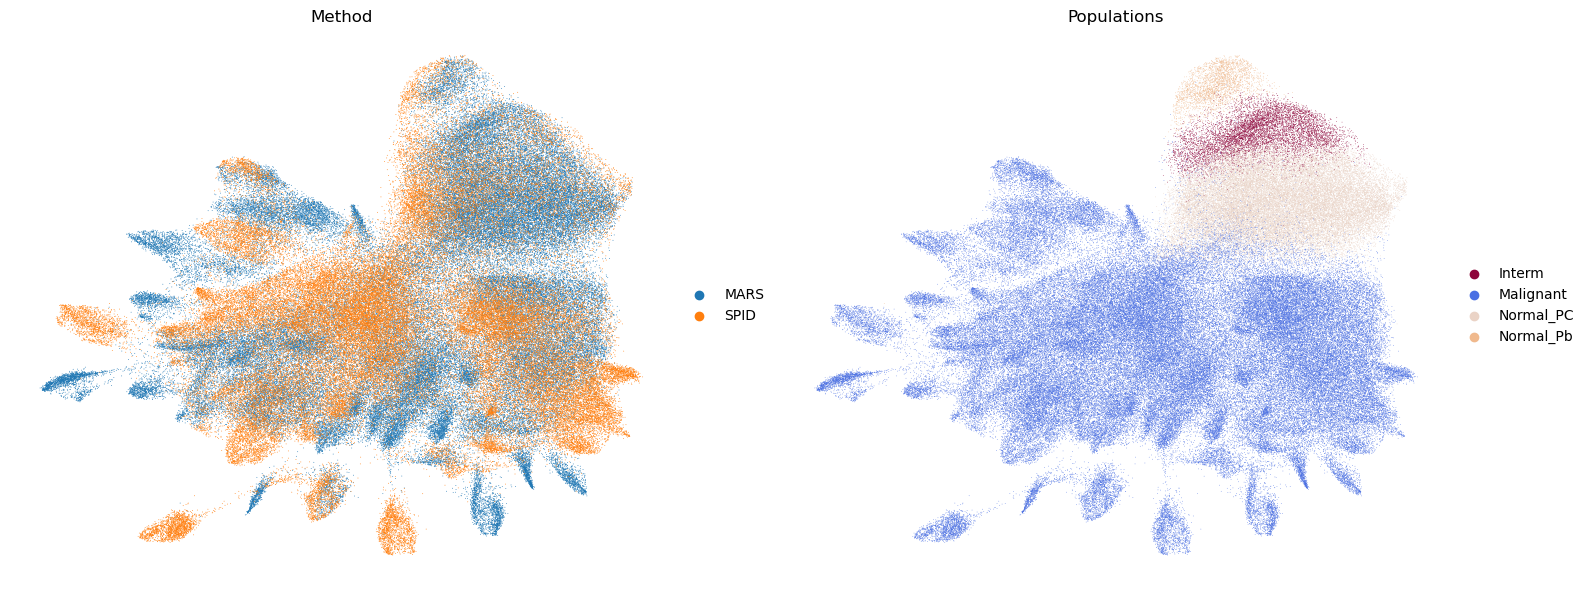

In [36]:
fig, axs = plt.subplots(1, 2, figsize=(16, 6))
sc.pl.umap(adata_proc, color='Method', 
           #palette=pal_method, 
           size=1.5, 
           frameon=False,
           ax=axs[0],
           show=False
           )
sc.pl.umap(adata_proc, color='Populations', 
           #palette=pal_method, 
           size=1., 
           frameon=False,
           ax=axs[1],
           show=False
           )
plt.tight_layout()
plt.show()

In [ ]:
# # save adata

# object_columns = adata_proc.obs.select_dtypes(include=['object']).columns
# for col in object_columns:
#     adata_proc.obs[col] = adata_proc.obs[col].astype(str)
# datetime_columns = adata_proc.obs.select_dtypes(include=['datetime64']).columns
# for col in datetime_columns:
#     adata_proc.obs[col] = adata_proc.obs[col].dt.strftime('%Y-%m-%d %H:%M:%S')
# name = os.path.join(data_path, f'adata_PC_with_ann_merged_v_{version}_UMAP.h5ad')
# adata_proc.write_h5ad(name)

# print(f'saved to {name}')

In [35]:
# # remove samples doubled between MARS and SPID (forgot to do before)

# name = os.path.join(data_path, f'adata_PC_with_ann_merged_v_{version}_UMAP.h5ad')
# adata_proc = ad.read_h5ad(name)

In [42]:
# sc.pl.umap(adata_proc, color =['FCRL5'], size = 5)

# sc.pl.dotplot(adata_proc,
#               groupby = ['Populations'],
#               var_names=['FCRL5', 'FCRL2', 'GPRC5D', 'TNFRSF17'],
#               mean_only_expressed = True,
#               categories_order=['Normal_Pb', 'Interm', 'Normal_PC', 'Malignant'])

In [24]:
df = adata_proc.obs.copy()
sample_method_counts = df.groupby('Sample.Code')['Method'].nunique()
duplicated_samples = sample_method_counts[sample_method_counts > 1].index.tolist()
print(f"{len(duplicated_samples)} samples sequenced with multiple methods:")
print(duplicated_samples)

malignant_df = (df[df['Sample.Code'].isin(duplicated_samples)]
                .groupby(['Sample.Code', 'Method'], observed=True)
                .agg(n_malignant=('Populations', lambda x: (x == 'Malignant').sum()),
                     total_cells=('Populations', 'size'))
                .reset_index())

print("\nMalignant cell counts per sample-method:")
print(malignant_df)

remove_list = []

for sample in duplicated_samples:
    sample_data = malignant_df[malignant_df['Sample.Code'] == sample]
    
    if len(sample_data) != 2:
        continue
    
    min_idx = sample_data['n_malignant'].idxmin()
    method_to_remove = sample_data.loc[min_idx, 'Method']
    
    remove_list.append({
        'Sample.Code': sample,
        'Method': method_to_remove
    })

remove_df = pd.DataFrame(remove_list)
    
print("\nSamples to remove (method with fewer malignant cells):")
print(remove_df)

adata_proc.obs['cells_rem_dupl_between_methods'] = False

for _, row in remove_df.iterrows():
    mask = (adata_proc.obs['Sample.Code'] == row['Sample.Code']) & \
           (adata_proc.obs['Method'] == row['Method'])
    adata_proc.obs.loc[mask, 'cells_rem_dupl_between_methods'] = True

print(f"\nCells marked: {adata_proc.obs['cells_rem_dupl_between_methods'].sum()}")
print(f"Total cells: {adata_proc.n_obs}")

7 samples sequenced with multiple methods:
['cart_p19_1', 'cart_p21_1', 'cart_p24_1', 'cart_p36_1', 'tlv48_1', 'tlv53_1', 'tlv69_1']

Malignant cell counts per sample-method:
   Sample.Code Method  n_malignant  total_cells
0   cart_p19_1   MARS          195          195
1   cart_p19_1   SPID           13           56
2   cart_p21_1   MARS          414          415
3   cart_p21_1   SPID          149          150
4   cart_p24_1   MARS          867          869
5   cart_p24_1   SPID         1373         1381
6   cart_p36_1   MARS          891          891
7   cart_p36_1   SPID          271          275
8      tlv48_1   MARS          104          106
9      tlv48_1   SPID            4           14
10     tlv53_1   MARS          898          994
11     tlv53_1   SPID          201          270
12     tlv69_1   MARS            6            8
13     tlv69_1   SPID          638          780

Samples to remove (method with fewer malignant cells):
  Sample.Code Method
0  cart_p19_1   SPID
1  cart

/tmp/ipykernel_215559/1816597936.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  sample_method_counts = df.groupby('Sample.Code')['Method'].nunique()


In [25]:
# save adata

object_columns = adata_proc.obs.select_dtypes(include=['object']).columns
for col in object_columns:
    adata_proc.obs[col] = adata_proc.obs[col].astype(str)
datetime_columns = adata_proc.obs.select_dtypes(include=['datetime64']).columns
for col in datetime_columns:
    adata_proc.obs[col] = adata_proc.obs[col].dt.strftime('%Y-%m-%d %H:%M:%S')
name = os.path.join(data_path, f'adata_PC_with_ann_merged_v_{version}_UMAP.h5ad')
adata_proc.write_h5ad(name)
print(f'saved to {name}')

/home/projects/amit/annaku/miniconda3/envs/cell2cell_env/lib/python3.12/site-packages/anndata/_io/utils.py:243: FutureWarning: Forward slashes will be disallowed in h5 stores in the next minor release
  return func(*args, **kwargs)


saved to /home/projects/amit/annaku/repos/Blueprint/data/processed/adata_PC_with_ann_merged_v_20250306_UMAP.h5ad


In [27]:
# counts h5ad file
filename = f'pp_adata_data_v_{version}.h5ad'
adata_pp = ad.read_h5ad(os.path.join(data_path, filename)) # raw after basic QC

name = os.path.join(data_path, f'adata_PC_with_ann_merged_v_{version}_UMAP.h5ad')
adata_proc = ad.read_h5ad(name)

adata = ad.AnnData(X=adata_pp.X.copy(), obs=adata_pp.obs.copy(), var=adata_pp.var.copy(),
                       obsm=adata_pp.obsm, obsp=adata_pp.obsp, uns=adata_pp.uns
                       )
cells_to_left = adata_proc.obs.index
adata = adata[cells_to_left, :]
adata.obs = adata_proc.copy().obs
adata

AnnData object with n_obs × n_vars = 184247 × 52317
    obs: 'Unnamed: 0', 'Amp.Batch.ID', 'Seq.Batch.ID', 'Batch.Set.ID', 'Included', 'Tissue', 'Gating', 'Total.PC', 'Total.NonPC', 'Initial.Code', 'Disease', 'Time', 'Project', 'Cohort', 'Weizmann.Code', 'Hospital.Code', 'Clinical.Data', 'Biopsy.Sequence', 'Previous.Hospital.Code', 'Method', 'cID', 'super_Population', 'Populations', 'n_genes', 'n_counts', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', '_scvi_batch', '_scvi_labels', 'leiden', 'Predicted', 'count_of_CD45_in_neighborhood', 'count_of_PC_in_neighborhood', 'bad_pcs', 'bad_pcs_leiden', 'bad_pcs_all', 'pc_close_other_pc', 'bad_cd45s', 'bad_cd45s_leiden', 'bad_cd45s_all', 'Sample.Code', 'Populations_with_pc_and_pb', 'Populations_with_pc', 'source_project', 'Original Code', 'Code', 'Transcriptome', 'Patient Code', 'Biopsy sequence No.', 'Plasma cell dyscrasia at Bx time(0=NDMM, 1=RRMM, 2=SMM 3=MGUS,4=NDAL, 5=RRAL, 6=NDSPC, 7=MGRS, 8=None, 10=Naïve_NDMM)

In [28]:
# add umap data to adata with counts

adata.obsm['X_scVI'] = adata_proc.obsm['X_scVI']
adata.obsm['X_umap'] = adata_proc.obsm['X_umap']
adata.obsp['distances'] = adata_proc.obsp['distances']
adata.obsp['connectivities'] = adata_proc.obsp['connectivities']
adata.obsp['tme_distances'] = adata_proc.obsp['tme_distances']
adata.obsp['tme_connectivities'] = adata_proc.obsp['tme_connectivities']
adata.obsp['pc_distances'] = adata_proc.obsp['pc_distances']
adata.obsp['pc_connectivities'] = adata_proc.obsp['pc_connectivities']
adata.uns['neighbors'] = adata_proc.uns['neighbors']
adata.var['HVG_scVI'] = adata.var_names.isin(adata_proc.var_names)

In [31]:
# save adata

object_columns = adata.obs.select_dtypes(include=['object']).columns
for col in object_columns:
    adata.obs[col] = adata.obs[col].astype(str)
datetime_columns = adata.obs.select_dtypes(include=['datetime64']).columns
for col in datetime_columns:
    adata.obs[col] = adata.obs[col].dt.strftime('%Y-%m-%d %H:%M:%S')
name = os.path.join(data_path, f'adata_PC_with_ann_merged_v_{version}.h5ad')
adata.write_h5ad(name)

print(f'saved to {name}')

/home/projects/amit/annaku/miniconda3/envs/cell2cell_env/lib/python3.12/site-packages/anndata/_io/utils.py:243: FutureWarning: Forward slashes will be disallowed in h5 stores in the next minor release
  return func(*args, **kwargs)


saved to /home/projects/amit/annaku/repos/Blueprint/data/processed/adata_PC_with_ann_merged_v_20250306.h5ad


# save for zscores calculation in R

In [8]:
name = os.path.join(data_path, f'adata_PC_with_ann_merged_v_{version}.h5ad')
adata_counts = ad.read_h5ad(name)
adata_counts = adata_counts[adata_counts.obs['cells_rem_dupl_between_methods'] == False]
adata_counts

View of AnnData object with n_obs × n_vars = 182605 × 52317
    obs: 'Unnamed: 0', 'Amp.Batch.ID', 'Seq.Batch.ID', 'Batch.Set.ID', 'Included', 'Tissue', 'Gating', 'Total.PC', 'Total.NonPC', 'Initial.Code', 'Disease', 'Time', 'Project', 'Cohort', 'Weizmann.Code', 'Hospital.Code', 'Clinical.Data', 'Biopsy.Sequence', 'Previous.Hospital.Code', 'Method', 'cID', 'super_Population', 'Populations', 'n_genes', 'n_counts', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', '_scvi_batch', '_scvi_labels', 'leiden', 'Predicted', 'count_of_CD45_in_neighborhood', 'count_of_PC_in_neighborhood', 'bad_pcs', 'bad_pcs_leiden', 'bad_pcs_all', 'pc_close_other_pc', 'bad_cd45s', 'bad_cd45s_leiden', 'bad_cd45s_all', 'Sample.Code', 'Populations_with_pc_and_pb', 'Populations_with_pc', 'source_project', 'Original Code', 'Code', 'Transcriptome', 'Patient Code', 'Biopsy sequence No.', 'Plasma cell dyscrasia at Bx time(0=NDMM, 1=RRMM, 2=SMM 3=MGUS,4=NDAL, 5=RRAL, 6=NDSPC, 7=MGRS, 8=None, 10=Naï

In [37]:
adata_counts.obs['Code'] = adata_counts.obs['Hospital.Code'].astype(str) + '_' + adata_counts.obs['Biopsy.Sequence'].astype(str).str.lower()
columns_to_extract = ['Amp.Batch.ID', 'Seq.Batch.ID', 'Method', 'Tissue', 'Disease', 'Hospital.Code', 'Biopsy.Sequence', 'Code', 'Populations'
                      ]
cells_all = adata_counts.obs[columns_to_extract]
cells_all.to_csv(data_path + f'/zscore_outputs/cells_all_v_{version}.csv')

/tmp/ipykernel_215559/274081437.py:1: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata_counts.obs['Code'] = adata_counts.obs['Hospital.Code'].astype(str) + '_' + adata_counts.obs['Biopsy.Sequence'].astype(str).str.lower()


In [38]:
genes = adata_counts.var_names.to_numpy()
np.savetxt(data_path + f'/zscore_outputs/genes_forz_v_{version}.txt', genes, fmt='%s')
cells = adata_counts.obs_names.to_numpy()
np.savetxt(data_path + f'/zscore_outputs/cells_forz_v_{version}.txt', cells, fmt='%s')
mat_ds = adata_counts.X.T
import scipy.io
scipy.io.mmwrite(data_path + f'/zscore_outputs/matrix_forz_v_{version}.mtx', mat_ds)